<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/vin_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn

data = yf.download(tickers='AAPL', start='2008-01-01', end='2024-01-01')
data.head(10)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

[*********************100%%**********************]  1 of 1 completed


'cpu'

In [162]:
data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)

In [163]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Target,TargetClass,TargetNextClose
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.891121,1079178800,-1.085084,0,5.893845
1,2008-01-03,6.978929,7.049643,6.881786,6.961786,5.893845,842066400,-1.393564,0,5.443936
2,2008-01-04,6.837500,6.892857,6.388929,6.430357,5.443936,1455832000,-1.102144,0,5.371070
3,2008-01-07,6.473214,6.557143,6.079643,6.344286,5.371070,2072193200,-1.255708,0,5.177863
4,2008-01-08,6.433571,6.516429,6.100000,6.116071,5.177863,1523816000,-0.693572,0,5.424285
...,...,...,...,...,...,...,...,...,...,...
4021,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.431885,46482500,-1.826706,0,193.353287
4022,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,-0.806015,0,192.803986
4023,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,0.413834,1,192.903839
4024,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,-0.806702,0,193.333298


In [164]:
df = data[['Date', 'Target']]

In [165]:
df

,Date,Target
0,2008-01-02,-1.085084
1,2008-01-03,-1.393564
2,2008-01-04,-1.102144
3,2008-01-07,-1.255708
4,2008-01-08,-0.693572
...,...,...
4021,2023-12-21,-1.826706
4022,2023-12-22,-0.806015
4023,2023-12-26,0.413834
4024,2023-12-27,-0.806702


In [166]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Target(t-{i})'] = df['Target'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Target,Target(t-1),Target(t-2),Target(t-3),Target(t-4),Target(t-5),Target(t-6),Target(t-7)
Date,,,,,,,,
2008-01-11,-0.934463,-1.064314,-0.959585,-0.693572,-1.255708,-1.102144,-1.393564,-1.085084
2008-01-14,-1.236103,-0.934463,-1.064314,-0.959585,-0.693572,-1.255708,-1.102144,-1.393564
2008-01-15,-1.074244,-1.236103,-0.934463,-1.064314,-0.959585,-0.693572,-1.255708,-1.102144
2008-01-16,-0.903594,-1.074244,-1.236103,-0.934463,-1.064314,-0.959585,-0.693572,-1.255708
2008-01-17,-0.896525,-0.903594,-1.074244,-1.236103,-0.934463,-1.064314,-0.959585,-0.693572
...,...,...,...,...,...,...,...,...
2023-12-21,-1.826706,-1.668121,-2.318283,0.529022,-0.449646,-0.211777,-0.162476,2.617722
2023-12-22,-0.806015,-1.826706,-1.668121,-2.318283,0.529022,-0.449646,-0.211777,-0.162476
2023-12-26,0.413834,-0.806015,-1.826706,-1.668121,-2.318283,0.529022,-0.449646,-0.211777


In [167]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[-0.93446302, -1.06431389, -0.95958519, ..., -1.10214376,
        -1.39356375, -1.08508444],
       [-1.23610258, -0.93446302, -1.06431389, ..., -1.25570774,
        -1.10214376, -1.39356375],
       [-1.07424355, -1.23610258, -0.93446302, ..., -0.69357204,
        -1.25570774, -1.10214376],
       ...,
       [ 0.41383362, -0.80601501, -1.82670593, ...,  0.52902222,
        -0.449646  , -0.21177673],
       [-0.80670166,  0.41383362, -0.80601501, ..., -2.31828308,
         0.52902222, -0.449646  ],
       [-1.61535645, -0.80670166,  0.41383362, ..., -1.66812134,
        -2.31828308,  0.52902222]])

In [168]:
shifted_df_as_np.shape

(4019, 8)

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.05753764, -0.0723741 , -0.06040804, ..., -0.07669646,
        -0.10999344, -0.0747473 ],
       [-0.09200229, -0.05753764, -0.0723741 , ..., -0.09424233,
        -0.07669646, -0.10999344],
       [-0.07350864, -0.09200229, -0.05753764, ..., -0.03001399,
        -0.09424233, -0.07669646],
       ...,
       [ 0.09651566, -0.04286146, -0.15948328, ...,  0.10967685,
        -0.00214355,  0.02503485],
       [-0.04293992,  0.09651566, -0.04286146, ..., -0.21564976,
         0.10967685, -0.00214355],
       [-0.13533497, -0.04293992,  0.09651566, ..., -0.14136377,
        -0.21564976,  0.10967685]])

In [170]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((4019, 7), (4019,))

In [171]:
X = dc(np.flip(X, axis=1))
X

array([[-0.0747473 , -0.10999344, -0.07669646, ..., -0.03001399,
        -0.06040804, -0.0723741 ],
       [-0.10999344, -0.07669646, -0.09424233, ..., -0.06040804,
        -0.0723741 , -0.05753764],
       [-0.07669646, -0.09424233, -0.03001399, ..., -0.0723741 ,
        -0.05753764, -0.09200229],
       ...,
       [ 0.02503485, -0.00214355,  0.10967685, ..., -0.14136377,
        -0.15948328, -0.04286146],
       [-0.00214355,  0.10967685, -0.21564976, ..., -0.15948328,
        -0.04286146,  0.09651566],
       [ 0.10967685, -0.21564976, -0.14136377, ..., -0.04286146,
         0.09651566, -0.04293992]])

In [172]:
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3818, 7), (201, 7), (3818,), (201,))

In [173]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3818, 7, 1), (201, 7, 1), (3818, 1), (201, 1))

In [174]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3818, 7, 1]),
 torch.Size([201, 7, 1]),
 torch.Size([3818, 1]),
 torch.Size([201, 1]))

In [175]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [176]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [177]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [178]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 5)
        self.leacky_relu = nn.LeakyReLU(0.2)
        self.second_lin = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.leacky_relu(self.second_lin(self.leacky_relu(self.fc(out[:, -1, :]))))
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=5, bias=True)
  (leacky_relu): LeakyReLU(negative_slope=0.2)
  (second_lin): Linear(in_features=5, out_features=1, bias=True)
)

In [179]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device).type(torch.float32), batch[1].to(device).type(torch.float32)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [180]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device).type(torch.float32), batch[1].to(device).type(torch.float32)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [199]:
from torchmetrics.regression import MeanAbsolutePercentageError

learning_rate = 0.01
num_epochs = 100
#loss_function = MeanAbsolutePercentageError()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.015
Batch 200, Loss: 0.016

Val Loss: 0.047
***************************************************

Epoch: 2
Batch 100, Loss: 0.018
Batch 200, Loss: 0.014

Val Loss: 0.044
***************************************************

Epoch: 3
Batch 100, Loss: 0.014
Batch 200, Loss: 0.016

Val Loss: 0.042
***************************************************

Epoch: 4
Batch 100, Loss: 0.016
Batch 200, Loss: 0.013

Val Loss: 0.049
***************************************************

Epoch: 5
Batch 100, Loss: 0.012
Batch 200, Loss: 0.017

Val Loss: 0.046
***************************************************

Epoch: 6
Batch 100, Loss: 0.016
Batch 200, Loss: 0.015

Val Loss: 0.040
***************************************************

Epoch: 7
Batch 100, Loss: 0.015
Batch 200, Loss: 0.017

Val Loss: 0.044
***************************************************

Epoch: 8
Batch 100, Loss: 0.014
Batch 200, Loss: 0.017

Val Loss: 0.044
***************************************************



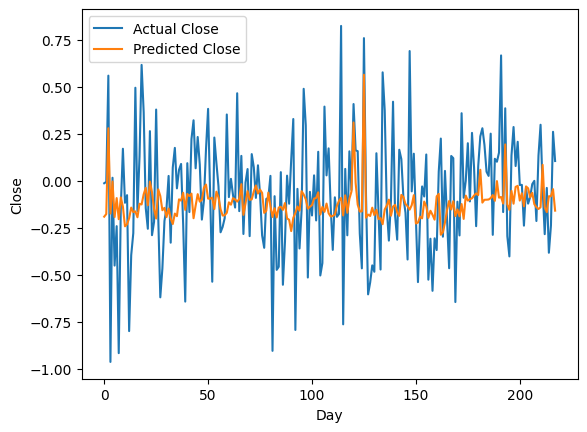

In [207]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[3600:], label='Actual Close')
plt.plot(predicted[3600:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [201]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-1.60743476, -1.24102921, -1.18269774, ..., -1.14002181,
       -0.80807226, -1.80989845])

In [202]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-0.93446303, -1.23610257, -1.07424353, ..., -2.49844365,
        1.86109934,  0.49984739])

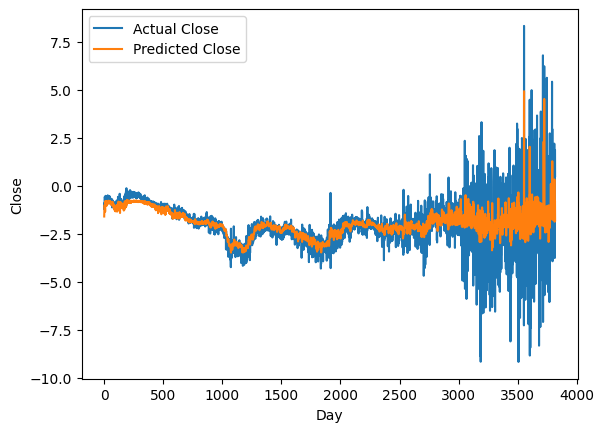

In [203]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [204]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [205]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

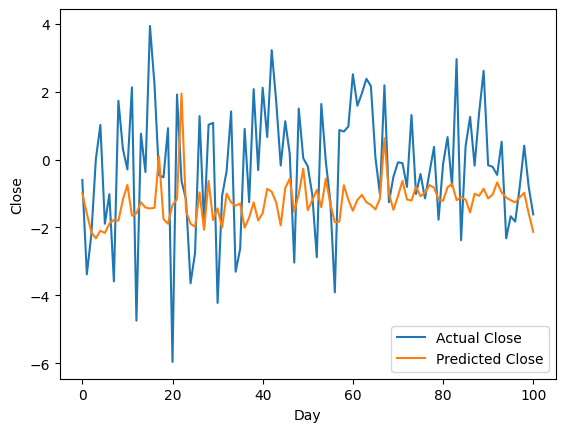

In [206]:
plt.plot(new_y_test[100:], label='Actual Close')
plt.plot(test_predictions[100:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()